# EDA of US Census Archive data

In [1]:
# %load_ext autoreload
# %autoreload 2

import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath("../"))

from src.data_validation import extract_schema

## Data quality assessment

In [2]:
schema = extract_schema('../data/census_income_metadata.txt')

In [3]:
schema['salary']

['-50000', '50000']

In [4]:
census_income_learn = pd.read_csv('../data/census_income_learn.csv', names = schema.keys(), index_col=False)
census_income_test = pd.read_csv('../data/census_income_test.csv', names = schema.keys(), index_col=False)

In [7]:
len(census_income_learn) == len(census_income_learn.drop_duplicates())

False

In [8]:
census_income_learn_clean = census_income_learn.drop_duplicates()

There are duplicate rows in the data - we will drop these.

In [9]:
census_income_learn_clean.isna().sum().sum()

0

There are no missing values in the data - values labelled as 'Not in universe' can be interpreted as meaning that the column in question is not applicable to them. We will judge on a case by case basis whether this means the value should be treated as missing, or is a useful label to include in the definition of a feature variable.

## Exploratory data analysis

How many surveyed earn more than $50,000 compared to under $50,000?

In [10]:
census_income_learn_clean['salary'].value_counts(normalize=True)

salary
- 50000.    0.936921
50000+.     0.063079
Name: proportion, dtype: float64

We will likely need to account for this class imblance in our classification model. Let's look at some bivariate plots and see what features might be good predictors of salary band.

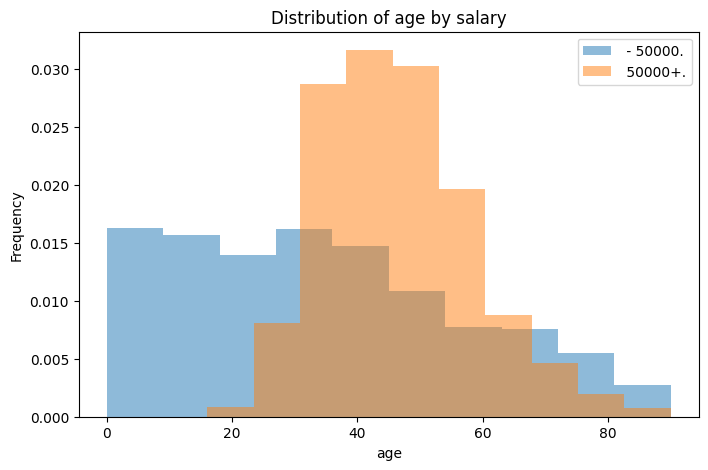

In [11]:
# Separate data by group
groups = census_income_learn_clean['salary'].unique()

# Plot overlapping histograms
plt.figure(figsize=(8,5))
for g in groups:
    plt.hist(
        census_income_learn_clean.loc[census_income_learn_clean["salary"] == g, "age"],
        bins=10,
        alpha=0.5,            # transparency
        label=g,
        density=True          # normalize to compare shape
    )

plt.xlabel("age")
plt.ylabel("Frequency")
plt.title("Distribution of age by salary")
plt.legend()
plt.show()

It's not surprising that anyone under the age of 20 is earning less than $50,000 (most of these are probably not earning anything!). It's also not surprising that older people are earning less since most are likely in retirement. It's entirely expected that working age people are most likely to earn more. This suggests a strong relationship between age and salary, but one that isn't linear! For our initial model, I would consider grouping this quantity into 20-year age bins, where for more complex models we can leave as continuous.

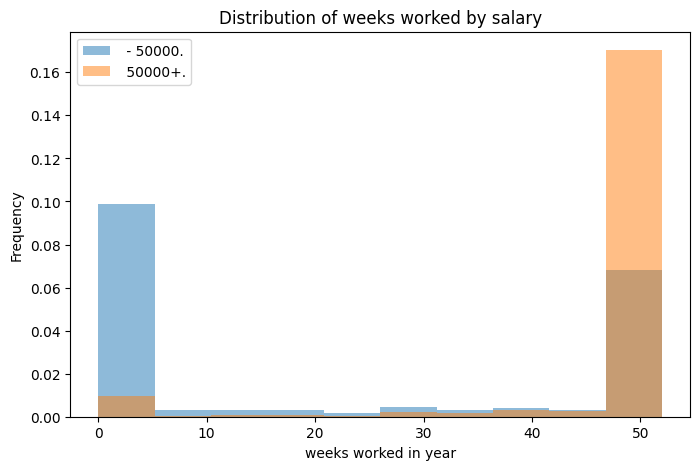

In [12]:
plt.figure(figsize=(8,5))
for g in groups:
    plt.hist(
        census_income_learn_clean.loc[census_income_learn["salary"] == g, "weeks worked in year"],
        bins=10,
        alpha=0.5,            # transparency
        label=g,
        density=True          # normalize to compare shape
    )

plt.xlabel("weeks worked in year")
plt.ylabel("Frequency")
plt.title("Distribution of weeks worked by salary")
plt.legend()
plt.show()

Here we can see that people who work most or all year round are more likely to earn over $50,000. I would keep this variable as is.

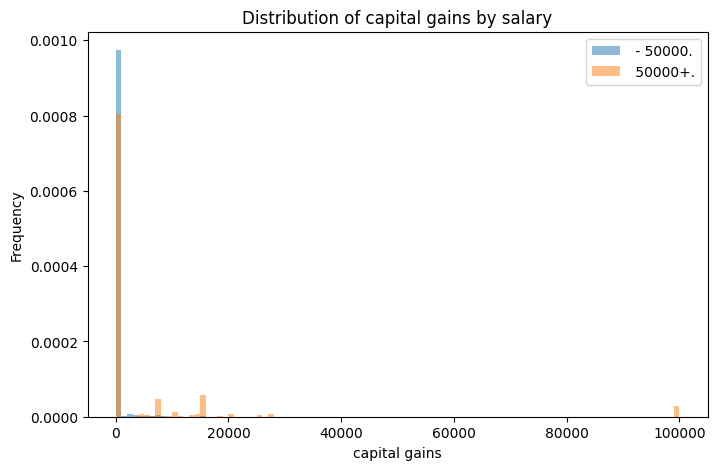

In [13]:
plt.figure(figsize=(8,5))
for g in groups:
    plt.hist(
        census_income_learn_clean.loc[census_income_learn_clean["salary"] == g, "capital gains"],
        bins=100,
        alpha=0.5,            # transparency
        label=g,
        density=True          # normalize to compare shape
    )

plt.xlabel("capital gains")
plt.ylabel("Frequency")
plt.title("Distribution of capital gains by salary")
plt.legend()
plt.show()

Here, we see that people receiving investment income are more likely to earn over $50,000 - because the distribution is so skewed I'd recommend taking log(x+1) of this variable during feature engineering.

In [14]:
census_income_learn_clean['education'].unique()

array([' High school graduate', ' Some college but no degree',
       ' 10th grade', ' Children', ' Bachelors degree(BA AB BS)',
       ' Masters degree(MA MS MEng MEd MSW MBA)', ' Less than 1st grade',
       ' Associates degree-academic program', ' 7th and 8th grade',
       ' 12th grade no diploma', ' Associates degree-occup /vocational',
       ' Prof school degree (MD DDS DVM LLB JD)', ' 5th or 6th grade',
       ' 11th grade', ' Doctorate degree(PhD EdD)', ' 9th grade',
       ' 1st 2nd 3rd or 4th grade'], dtype=object)

In [15]:
census_income_learn_clean.groupby('education')['salary'].value_counts(normalize=True)

education                               salary  
10th grade                              - 50000.    0.991776
                                        50000+.     0.008224
11th grade                              - 50000.    0.989799
                                        50000+.     0.010201
12th grade no diploma                   - 50000.    0.984000
                                        50000+.     0.016000
1st 2nd 3rd or 4th grade                - 50000.    0.992774
                                        50000+.     0.007226
5th or 6th grade                        - 50000.    0.993287
                                        50000+.     0.006713
7th and 8th grade                       - 50000.    0.990973
                                        50000+.     0.009027
9th grade                               - 50000.    0.993864
                                        50000+.     0.006136
Associates degree-academic program      - 50000.    0.905570
                                    

Education is clearly a strong indicator of earnings with over half of PhDs earning over $50,000 with less than 1% of people reaching 9th grade earning this amount. These categories are a little specific and will be difficult to use in a model without strong regularisation. I recommend the following coarse mapping:

- Children: Children
- Primary school: Less than 1st grade, 1st 2nd 3rd or 4th grade, 5th or 6th grade, 7th or 8th grade, 9th grade, 10th grade, 11th grade, 12th grade no diploma
- High school graduate: High school graduate, Some college but no degree
- Associate degree: Associayes degree-academic program, Associates degree-occup /vocational
- Bachelors degree: Bachelors degree(BA AB BS)
- Postgrad or Prof degree: Doctorate degree, Masters degree, Prof school degree


In [16]:
census_income_learn_clean.groupby('sex')['salary'].value_counts(normalize=True)

sex     salary  
Female  - 50000.    0.973994
        50000+.     0.026006
Male    - 50000.    0.896490
        50000+.     0.103510
Name: proportion, dtype: float64

Men are more likely to earn over $50,000 - this will be a useful feature.

In [17]:
census_income_learn_clean.groupby('race')['salary'].value_counts(normalize=True)

race                         salary  
Amer Indian Aleut or Eskimo  - 50000.    0.978145
                             50000+.     0.021855
Asian or Pacific Islander    - 50000.    0.926130
                             50000+.     0.073870
Black                        - 50000.    0.973275
                             50000+.     0.026725
Other                        - 50000.    0.975034
                             50000+.     0.024966
White                        - 50000.    0.931427
                             50000+.     0.068573
Name: proportion, dtype: float64

Race is a pretty strong indicator of earnings as well. I'd rather not make this field more coarse.

In [18]:
census_income_learn_clean.groupby('class of worker')['salary'].value_counts(normalize=True)

class of worker                 salary  
Federal government              - 50000.    0.795897
                                50000+.     0.204103
Local government                - 50000.    0.891173
                                50000+.     0.108827
Never worked                    - 50000.    0.995434
                                50000+.     0.004566
Not in universe                 - 50000.    0.990683
                                50000+.     0.009317
Private                         - 50000.    0.898335
                                50000+.     0.101665
Self-employed-incorporated      - 50000.    0.652574
                                50000+.     0.347426
Self-employed-not incorporated  - 50000.    0.870884
                                50000+.     0.129116
State government                - 50000.    0.885261
                                50000+.     0.114739
Without pay                     - 50000.    0.993939
                                50000+.     0.006061
Name:

There is quite strong variation in earnings between people of different employment types. But let's create a more coarse version of this dataset to reduce the number of categories. Consider the coarse mapping:

- Government: Federal, local, state government
- Private: Private
- Self-employed: Self-employed-incorporated, self-employed-not incorporated
- No pay: Without pay, never worked
- Not in universe: Not in universe

Not in universe here likely includes children and students - it is therefore a useful indicator of earnings and we treat it as a category rather than as a missing value.

In [19]:
census_income_learn_clean.groupby('major industry code')['salary'].value_counts(normalize=True)

major industry code                  salary  
Agriculture                          - 50000.    0.941079
                                     50000+.     0.058921
Armed Forces                         - 50000.    0.777778
                                     50000+.     0.222222
Business and repair services         - 50000.    0.890462
                                     50000+.     0.109538
Communications                       - 50000.    0.771380
                                     50000+.     0.228620
Construction                         - 50000.    0.910929
                                     50000+.     0.089071
Education                            - 50000.    0.892430
                                     50000+.     0.107570
Entertainment                        - 50000.    0.931515
                                     50000+.     0.068485
Finance insurance and real estate    - 50000.    0.817901
                                     50000+.     0.182099
Forestry and fisheries    

In [20]:
len(census_income_learn['major industry code'].unique())

24

There are substantial differences between industries but the number of categories is quite large and will be difficult to encode in a simple model. There's also no meaningful way to group these, so I would be reluctant to include this feature in a model without regularisation.

In [21]:
census_income_learn_clean.groupby('major occupation code')['salary'].value_counts(normalize=True)

major occupation code                  salary  
Adm support including clerical         - 50000.    0.969938
                                       50000+.     0.030062
Armed Forces                           - 50000.    0.777778
                                       50000+.     0.222222
Executive admin and managerial         - 50000.    0.712445
                                       50000+.     0.287555
Farming forestry and fishing           - 50000.    0.949093
                                       50000+.     0.050907
Handlers equip cleaners etc            - 50000.    0.980853
                                       50000+.     0.019147
Machine operators assmblrs & inspctrs  - 50000.    0.963149
                                       50000+.     0.036851
Not in universe                        - 50000.    0.990705
                                       50000+.     0.009295
Other service                          - 50000.    0.990080
                                       50000+.     0

In [22]:
len(census_income_learn_clean['major occupation code'].unique())

15

Similarly, there are marked differences between occupation types but a large number of categories. However, there is a lot of crossover with the industry codes and at a coarser scale. I don't think we need to include both, but I'd still like to reduce the number of categories - let's do some grouping here to reduce the cardinality of this feature and make outcomes more interpretable. I recommend the following mapping:

- Professional: Executive admin and managerial, Professional specialty, Technicians and related support
- Clerical: Adm support including clerical, Sales, Other service, Private household service
- Blue-collar: Precision production craft & repair, Machine operators assmblrs & inspctrs, Handlers equip cleaners etc, Transportation and material moving, Protective services, Farming forestry and fishing
- Armed Forces: Armed Forces
- Not in universe: Not in universe

Not in universe here likely includes children and students - it is therefore a useful indicator of earnings and we treat it as a category rather than as a missing value.

In [23]:
census_income_learn_clean.groupby('marital stat')['salary'].value_counts(normalize=True)

marital stat                     salary  
Divorced                         - 50000.    0.916109
                                 50000+.     0.083891
Married-A F spouse present       - 50000.    0.977444
                                 50000+.     0.022556
Married-civilian spouse present  - 50000.    0.885978
                                 50000+.     0.114022
Married-spouse absent            - 50000.    0.936717
                                 50000+.     0.063283
Never married                    - 50000.    0.986590
                                 50000+.     0.013410
Separated                        - 50000.    0.954322
                                 50000+.     0.045678
Widowed                          - 50000.    0.968439
                                 50000+.     0.031561
Name: proportion, dtype: float64

There are some marked differences in earnings with marital status too. Some of this will be correlated with age - most people labelled as 'never married' will be children and obviously not earning. It is still a useful indicator but will not be as important as age. To add some nuance here, we consider the following coarse mapping:

- Married, spouse present: Married-civilian spouse present, married-AF spouse present
- Married, spouse not present: Married-spouse absent, Separated
- Was married: Divorced, Widowed
- Single: Never married

In [24]:
census_income_learn_clean.groupby('full or part time employment stat')['salary'].value_counts(normalize=True)

full or part time employment stat   salary  
Children or Armed Forces            - 50000.    0.951306
                                    50000+.     0.048694
Full-time schedules                 - 50000.    0.868248
                                    50000+.     0.131752
Not in labor force                  - 50000.    0.982713
                                    50000+.     0.017287
PT for econ reasons usually FT      - 50000.    0.940952
                                    50000+.     0.059048
PT for econ reasons usually PT      - 50000.    0.871795
                                    50000+.     0.128205
PT for non-econ reasons usually FT  - 50000.    0.881698
                                    50000+.     0.118302
Unemployed full-time                - 50000.    0.964069
                                    50000+.     0.035931
Unemployed part- time               - 50000.    0.978622
                                    50000+.     0.021378
Name: proportion, dtype: float64

Not sure why children and armed forces are grouped together. Full time employees are more likely to earn over $50,000 than unemployed. This quantity will be heavily correlated with the worker class and occupation variables, particularly around frequency of unemployed people. To capture the broader differences between full and part time work, we recommend the following coarse mapping:

- Unemployed: Unemployed full-time, Unemployed part-time
- Part-time: PT for econ reasons usually FT, PT for econ reasons usually PT, PT for non-econ reasons usually FT
- Full-time: Full-time schedules
- Not in labor force: Not in labor force
- Children or Armed Forces: Children or Armed Forces

In [25]:
census_income_learn_clean.groupby('citizenship')['salary'].value_counts(normalize=True)

citizenship                                  salary  
Foreign born- Not a citizen of U S           - 50000.    0.963242
                                             50000+.     0.036758
Foreign born- U S citizen by naturalization  - 50000.    0.900872
                                             50000+.     0.099128
Native- Born abroad of American Parent(s)    - 50000.    0.926982
                                             50000+.     0.073018
Native- Born in Puerto Rico or U S Outlying  - 50000.    0.978275
                                             50000+.     0.021725
Native- Born in the United States            - 50000.    0.935846
                                             50000+.     0.064154
Name: proportion, dtype: float64

Some variation here, if not the strongest indicator. Let's simplify to:

- Native or citizen: Born abroad of American Parents, Born in Puerto Rico or US Outlying, Born in the United States, US Citizen by naturalisation
- Not citizen: Foreign born - Not a citizen of US

In [26]:
census_income_learn_clean.groupby('own business or self employed')['salary'].value_counts(normalize=True)

own business or self employed  salary  
0                              - 50000.    0.941097
                               50000+.     0.058903
1                              - 50000.    0.774277
                               50000+.     0.225723
2                              - 50000.    0.918209
                               50000+.     0.081791
Name: proportion, dtype: float64

Sole traders tend to earn more than people operating registered business entities which is a little surprising, but this is a useful feature too.

In [27]:
census_income_learn_clean.groupby('region of previous residence')['salary'].value_counts(normalize=True)

region of previous residence  salary  
Abroad                        - 50000.    0.966038
                              50000+.     0.033962
Midwest                       - 50000.    0.969373
                              50000+.     0.030627
Northeast                     - 50000.    0.945556
                              50000+.     0.054444
Not in universe               - 50000.    0.934848
                              50000+.     0.065152
South                         - 50000.    0.962256
                              50000+.     0.037744
West                          - 50000.    0.960669
                              50000+.     0.039331
Name: proportion, dtype: float64

There's not a lot of variation here so would be inclined to omit.

In [28]:
census_income_learn_clean['instance weight'].sum()

342192967.15

The instance weight quantity is the weight given to each surveyed individual - the sum of the weights makes up the population of the US (verified) - since we want to infer population-level salary bands we should use these weights in our modelling.

## Modelling strategy

Informed by the exploratory analysis, our modelling strategy is as follows:

1. Train model for predicting salary band for population using logistic regression with coarse features outlined in the EDA.
2. Train model for predicting salary band for population using XGBoost with coarse features outlined in the EDA.
3. Train model for predicting salary band for population using XGBoost with original granular features.